### Comparison of the Effectiveness of IR Methods

Import Library

In [72]:
!pip install pypdf2 nltk gdown faiss-cpu pdfplumber chromadb

#### Import Pustaka Python

In [73]:
import PyPDF2
import time
import re
import pandas as pd
import nltk
import numpy as np
import gdown
import pdfplumber
import matplotlib.pyplot as plt
import collections
import google.generativeai as genai
import chromadb
from sklearn.metrics.pairwise import cosine_similarity
from scipy.optimize import curve_fit
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from langchain.text_splitter import RecursiveCharacterTextSplitter
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
import seaborn as sns
from sklearn.metrics import precision_score, recall_score

In [74]:
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [75]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
API_KEY = 'YOUR_API_KEY'
COLLECTION_NAME = "YOUR_COLLECTION_NAME"
PERSIST_DIRECTORY = "YOUR_PERSIST_DIRECTORY"
EMBEDDING_MODEL = 'models/text-embedding-004'
GENERATION_MODEL = 'gemini-2.0-flash'

Embedding function

In [77]:
def get_google_generative_embedding_function(model=EMBEDDING_MODEL, api_key=API_KEY):
    """
    Mengembalikan fungsi untuk mendapatkan embedding dari teks menggunakan model Google Generative AI.
    """
    genai.configure(api_key=api_key)

    class GoogleGenerativeEmbeddingFunction:
        def __call__(self, input):
            embeddings = []
            for text in input:
                try:
                    embedding_result = genai.embed_content(
                        model=model,
                        content=text,
                        task_type="retrieval_document"
                    )
                    print(f"Tipe hasil embedding: {type(embedding_result)}")
                    if hasattr(embedding_result, 'embedding'):
                        embeddings.append(embedding_result.embedding)
                    elif isinstance(embedding_result, dict) and 'embedding' in embedding_result:
                        embeddings.append(embedding_result['embedding'])
                    elif isinstance(embedding_result, dict) and 'embeddings' in embedding_result:
                        embeddings.append(embedding_result['embeddings'][0])
                    else:
                        print(f"Struktur hasil embedding tidak terduga: {embedding_result}")
                        embeddings.append([0.0] * 768)
                except Exception as e:
                    print(f"Error pada teks '{text[:50]}...': {str(e)}")
                    embeddings.append([0.0] * 768)
            return embeddings

    return GoogleGenerativeEmbeddingFunction()

Initialize ChromaDB client

In [ ]:
def get_chroma_client(persist_directory=PERSIST_DIRECTORY):
    """
    Menginisialisasi dan mengembalikan client ChromaDB.

    Args:
        persist_directory (str): Direktori untuk penyimpanan database ChromaDB.

    Returns:
        client: Instance dari PersistentClient ChromaDB.
    """
    settings = chromadb.Settings(
        anonymized_telemetry=False,
        allow_reset=True,
        is_persistent=True
    )

    client = chromadb.PersistentClient(
        path=persist_directory,
        settings=settings
    )
    return client

Get or create collection

In [ ]:
def get_or_create_collection(chroma_client, collection_name=COLLECTION_NAME):
    """
    Mengambil atau membuat collection di ChromaDB.

    Args:
        chroma_client: Instance dari client ChromaDB.
        collection_name: Nama collection yang ingin diambil atau dibuat (default: COLLECTION_NAME).

    Returns:
        collection: Collection yang diambil atau baru dibuat.
    """
    try:
        embedding_function = get_google_generative_embedding_function()
        collection = chroma_client.get_collection(
            name=collection_name,
            embedding_function=embedding_function,
        )
        print(f"Collection '{collection_name}' sudah ada. Menggunakan collection yang ada.")
    except Exception:
        embedding_function = get_google_generative_embedding_function()
        collection = chroma_client.create_collection(
            name=collection_name,
            embedding_function=embedding_function
        )
        print(f"Collection '{collection_name}' berhasil dibuat.")

    return collection


Fungsi untuk mengunduh dan membuka file PDF

In [ ]:
def download_and_extract_text(pdf_url: str, output_filename: str = 'document.pdf') -> str:
    gdown.download(pdf_url, output_filename, quiet=False)
    pdf_text = ""
    with pdfplumber.open(output_filename) as pdf:
        for page in pdf.pages:
            page_text = page.extract_text()
            if page_text:  
                pdf_text += page_text
    return pdf_text

Fungsi untuk preprocessing teks (tokenisasi, case folding, dan chunking)

In [ ]:
def preprocess_text(pdf_text: str, chunk_size: int = 1024, chunk_overlap: int = 100) -> list:
    words_before = word_tokenize(pdf_text)

    words_lower = [word.lower() for word in words_before]

    processed_text = " ".join(words_lower)

    processed_text = re.sub(r'[^a-zA-Z0-9\s]', '', processed_text)

    processed_text = re.sub(r'\.{2,}', '.', processed_text)

    splitter = RecursiveCharacterTextSplitter(
        chunk_size=chunk_size,
        chunk_overlap=chunk_overlap,
        length_function=len,
        separators=["\n\n", "\n", " ", ""]
    )
    chunks = splitter.split_text(processed_text)
    for i, chunk in enumerate(chunks):
        print(f"Chunk {i}: {chunk}\n")

    return chunks

In [82]:
def add_documents_to_chroma(collection, documents, embeddings=None):
    """
    Menambahkan dokumen ke koleksi ChromaDB.

    Args:
        collection: Objek koleksi ChromaDB.
        documents (list): Daftar dokumen teks.
        embeddings (list, optional): Daftar vektor embedding. Jika None, akan dibuat embedding baru.

    Returns:
        tuple: (bool, float) - Status keberhasilan dan waktu pemrosesan dalam detik
    """
    start_time_add_to_collection = time.time()
    chunk_count = len(documents)
    start_id = collection.count()
    ids = [f"doc_{start_id + i}" for i in range(chunk_count)]

    if embeddings is None:
        embedding_function = get_google_generative_embedding_function()
        print("Menghasilkan embedding baru...")
        embeddings = embedding_function(documents)

    if embeddings and len(embeddings) > 0:
        print(f"Panjang embedding pertama: {len(embeddings[0])}")
        print(f"Sampel embedding pertama: {embeddings[0][:5]}...")
    else:
        print("PERINGATAN: Tidak ada embedding yang dihasilkan!")
        return False, 0

    batch_size = 100
    for i in range(0, chunk_count, batch_size):
        end_idx = min(i + batch_size, chunk_count)
        batch_chunks = documents[i:end_idx]
        batch_ids = ids[i:end_idx]
        batch_embeddings = embeddings[i:end_idx]

        try:
            collection.add(
                documents=batch_chunks,
                ids=batch_ids,
                embeddings=batch_embeddings
            )
            print(f"Menambahkan batch {i//batch_size + 1}/{(chunk_count - 1)//batch_size + 1} ke collection ChromaDB")
        except Exception as e:
            print(f"Error saat menambahkan batch ke ChromaDB: {str(e)}")
            return False, time.time() - start_time_add_to_collection

    end_time_add_to_collection = time.time()
    processing_time_add_to_collection = end_time_add_to_collection - start_time_add_to_collection
    print(f"Waktu proses menambahkan dokumen ke ChromaDB: {processing_time_add_to_collection:.4f} detik")

    return True, processing_time_add_to_collection

Fungsi untuk memproses dokumen dan menyimpan dalam dua format: ChromaDB dan in-memory

In [ ]:
def process_document(pdf_url: str):
    print(f"Memulai proses dokumen dari URL: {pdf_url}")

    pdf_text = download_and_extract_text(pdf_url)
    print(f"Berhasil mengunduh dan mengekstrak teks dari PDF: {len(pdf_text)} karakter")

    chunks = preprocess_text(pdf_text)
    print(f"Jumlah chunk setelah preprocessing: {len(chunks)}")

    embedding_function = get_google_generative_embedding_function()
    embeddings = embedding_function(chunks)

    chroma_client = get_chroma_client()
    collection = get_or_create_collection(chroma_client)

    success_chroma, processing_time_chroma = add_documents_to_chroma(collection, chunks, embeddings)

    print(f"Waktu untuk menambahkan ke ChromaDB: {processing_time_chroma:.4f} detik")

    print(f"Proses dokumen selesai. Total dokumen di ChromaDB: {collection.count()}")
    return True


In [84]:
def query_documents_with_index(query: str, top_k: int = 3):
    start_time = time.time()
    chroma_client = get_chroma_client()
    try:
        collection = get_or_create_collection(chroma_client)
    except Exception as e:
        end_time = time.time()
        search_duration = (end_time - start_time) * 1000
        raise ValueError(f"Collection tidak ditemukan: {str(e)}")
    results = collection.query(
        query_texts=[query],
        n_results=top_k
    )
    end_time = time.time()
    search_duration = (end_time - start_time) * 1000
    formatted_results = []
    for i in range(len(results['documents'][0])):
        formatted_results.append({
            "chunk": results['documents'][0][i],
            "score": results['distances'][0][i]
        })

    formatted_results.sort(key=lambda x: x["score"], reverse=True)

    formatted_results = formatted_results[:top_k]

    return formatted_results, search_duration

Fungsi untuk menghasilkan respons menggunakan Gemini

In [ ]:
def generate_response(query: str, relevant_chunks: list) -> str:
    """
    Menghasilkan respons menggunakan model Gemini berdasarkan konteks dari dokumen yang relevan.

    Args:
        query (str): Pertanyaan yang diajukan
        relevant_chunks (list): Potongan dokumen yang relevan dengan query

    Returns:
        str: Respons yang dihasilkan
    """
    genai.configure(api_key=API_KEY)

    context = "\n\n".join([chunk["chunk"] for chunk in relevant_chunks])

    prompt = f"""
    Berdasarkan informasi berikut:

    {context}

    Pertanyaan: {query}

    Berikan jawaban yang akurat dan relevan berdasarkan informasi di atas."
    """

    try:
        model = genai.GenerativeModel(GENERATION_MODEL)
        response = model.generate_content(prompt)
        return response.text
    except Exception as e:
        return f"Terjadi kesalahan saat menghasilkan respons: {str(e)}"

Fungsi untuk mengahapus isi data collction

In [86]:
# # delete data colection 'data_collection'

# def delete_chroma_collection(client, collection_name):
#     """Deletes a Chroma collection.

#     Args:
#         client: The ChromaDB client.
#         collection_name: The name of the collection to delete.
#     """
#     try:
#         client.delete_collection(name=collection_name)
#         print(f"Collection '{collection_name}' deleted successfully.")
#     except Exception as e:
#         print(f"Error deleting collection '{collection_name}': {e}")

# # Get ChromaDB client (assuming get_chroma_client() is defined elsewhere)
# chroma_client = get_chroma_client()

# # Delete the collection
# delete_chroma_collection(chroma_client, "data_del")


In [87]:
from collections import defaultdict
import math
from nltk.tokenize import word_tokenize

def build_proximity_search(chunk_documents):
    """ Membangun sistem pencarian berbasis Proximity Index dari kumpulan dokumen chunk.
    Parameter:
        chunk_documents (dict): Dictionary yang berisi 'ids' dan 'documents'
    Return:
        search_query (function): Fungsi pencarian yang dapat dipanggil dengan query
    """
    tokenized_chunks = {}
    for doc_id, text in zip(chunk_documents['ids'], chunk_documents['documents']):
        tokens = word_tokenize(text.lower())
        tokenized_chunks[doc_id] = tokens

    proximity_index = defaultdict(lambda: defaultdict(list))
    for doc_id, tokens in tokenized_chunks.items():
        for position, token in enumerate(tokens):
            proximity_index[token][doc_id].append(position)

    def search_query(query, max_distance=5):
        """ Melakukan pencarian query menggunakan Proximity Index.
        Parameter:
            query (str): Kata kunci yang ingin dicari.
            max_distance (int): Jarak maksimum antara kata dalam query agar dianggap relevan.

        Output:
            Menampilkan hasil pencarian dalam format teks.
            Mengembalikan dictionary berisi dokumen yang cocok dengan skornya.
        """
        query_tokens = word_tokenize(query.lower())
        matching_docs = defaultdict(int)

        for token in query_tokens:
            if token in proximity_index:
                for doc_id, positions in proximity_index[token].items():
                    for pos in positions:
                        for other_token in query_tokens:
                            if other_token != token and other_token in proximity_index:
                                for other_pos in proximity_index[other_token].get(doc_id, []):
                                    if abs(pos - other_pos) <= max_distance:
                                        matching_docs[doc_id] += 1

        sorted_results = sorted(matching_docs.items(), key=lambda x: x[1], reverse=True)

        if sorted_results:
            print("=== HASIL PROXIMITY SEARCH ===")
            for doc_id, score in sorted_results:
                print(f"\nChunk {doc_id} (Skor Proximity: {score})")
                print(" ".join(tokenized_chunks[doc_id]))
        else:
            print("Tidak ada hasil yang ditemukan dengan proximity search.")

        return matching_docs, tokenized_chunks, query_tokens

    return search_query, tokenized_chunks, proximity_index


In [88]:
def build_ranked_retrieval(tokenized_chunks, proximity_index):
    """ Membangun sistem ranked retrieval dengan TF-IDF dari dokumen yang telah diindeks.

    Parameter:
        tokenized_chunks (dict): Dictionary dokumen yang sudah ditokenisasi
        proximity_index (dict): Proximity index yang sudah dibuat

    Return:
        rank_results (function): Fungsi untuk melakukan ranking pada hasil proximity search
    """
    N = len(tokenized_chunks)
    idf = {}
    for token in proximity_index:
        doc_freq = len(proximity_index[token])
        idf[token] = math.log(N / (1 + doc_freq))

    tf = defaultdict(lambda: defaultdict(int))
    for doc_id, tokens in tokenized_chunks.items():
        doc_length = len(tokens)
        for token in tokens:
            tf[token][doc_id] += 1 / doc_length

    def rank_results(proximity_results, tokenized_chunks, query_tokens):
        """ Mengurutkan hasil proximity search menggunakan TF-IDF ranking

        Parameter:
            proximity_results (dict): Hasil dari proximity search
            tokenized_chunks (dict): Dokumen yang sudah ditokenisasi
            query_tokens (list): Token dari query pencarian

        Output:
            Menampilkan hasil ranked retrieval
            Mengembalikan hasil yang sudah diurutkan
        """
        tfidf_scores = defaultdict(float)

        for doc_id in proximity_results:
            for token in query_tokens:
                if token in proximity_index and doc_id in proximity_index[token]:
                    tfidf_scores[doc_id] += tf[token][doc_id] * idf.get(token, 0)

        ranked_results = sorted(tfidf_scores.items(), key=lambda x: x[1], reverse=True)

        if ranked_results:
            print("\n=== HASIL RANKED RETRIEVAL (TF-IDF) ===")
            for doc_id, score in ranked_results:
                print(f"\nChunk {doc_id} (Skor TF-IDF: {score:.4f})")
                print(" ".join(tokenized_chunks[doc_id]))
        else:
            print("\nTidak ada hasil yang dapat diurutkan dengan ranked retrieval.")

        return ranked_results

    return rank_results


Function to evaluate all retrieval methods

In [ ]:
def evaluate_retrieval_methods(queries, ground_truths, top_k=3):
    assert len(queries) == len(ground_truths), "Number of queries must match number of ground truths"

    results = {
        "Semantic_Search": [],
        "Proximity_Search": [],
        "Ranked_Retrieval": []
    }

    for i, (query, ground_truth) in enumerate(zip(queries, ground_truths)):
        print(f"\nEvaluating query {i+1}/{len(queries)}: {query}")

        chroma_results, chroma_duration = query_documents_with_index(query, top_k=top_k)
        result_chroma_db = " ".join([result['chunk'] for result in chroma_results])

        proximity_results, tokenized_chunks, query_tokens = search_query(query)

        proximity_items = list(proximity_results.items())

        top_proximity = sorted(proximity_items, key=lambda item: item[1], reverse=True)[:top_k]

        proximity_documents = []
        for doc_id, score in top_proximity:
            if doc_id in tokenized_chunks:
                proximity_documents.append(" ".join(tokenized_chunks[doc_id]))

        result_proximity = " ".join(proximity_documents)

        ranked_results = rank_results(proximity_results, tokenized_chunks, query_tokens)

        top_reranked = ranked_results[:top_k]

        ranked_documents = []
        for doc_id, score in top_reranked:
            for id, doc in zip(chunk_documents['ids'], chunk_documents['documents']):
                if id == doc_id:
                    ranked_documents.append(doc)
                    break

        result_ranked = " ".join(ranked_documents)

        retrieval_results = [result_chroma_db, result_proximity, result_ranked]

        vectorizer = TfidfVectorizer()

        texts = [ground_truth] + retrieval_results

        tfidf_matrix = vectorizer.fit_transform(texts)

        similarities = cosine_similarity(tfidf_matrix[0], tfidf_matrix[1:])[0]

        method_names = ["Semantic_Search", "Proximity_Search", "Ranked_Retrieval"]
        for method_name, score in zip(method_names, similarities):
            results[method_name].append(score)
            print(f"  {method_name}: {score:.4f}")

    return results

In [90]:
def visualize_query_comparison(results, test_queries):
    """
    Membuat visualisasi yang menampilkan perbandingan skor similaritas untuk setiap query
    """
    df = pd.DataFrame(results)

    df.index = [f"Query {i+1}" for i in range(len(test_queries))]

    plt.figure(figsize=(12, 8))
    sns.heatmap(df, annot=True, cmap='YlGnBu', fmt='.4f', linewidths=.5, cbar_kws={'label': 'Skor Similaritas'})
    plt.title('Perbandingan Skor Similaritas per Query untuk Setiap Metode', fontsize=16)
    plt.tight_layout()
    plt.savefig('query_comparison_heatmap.png')

    plt.figure(figsize=(14, 10))
    df.plot(kind='bar', figsize=(14, 8))
    plt.title('Skor Similaritas per Query untuk Setiap Metode', fontsize=16)
    plt.xlabel('Query', fontsize=14)
    plt.ylabel('Skor Similaritas', fontsize=14)
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.legend(title='Metode', fontsize=12)

    for container in plt.gca().containers:
        plt.gca().bar_label(container, fmt='%.4f', fontsize=9)

    plt.tight_layout()
    plt.savefig('query_comparison_bar.png')

    plt.figure(figsize=(10, 10))

    categories = df.index
    N = len(categories)
    angles = [n / float(N) * 2 * np.pi for n in range(N)]
    angles += angles[:1]

    ax = plt.subplot(111, polar=True)

    colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
    for i, method in enumerate(df.columns):
        values = df[method].values.tolist()
        values += values[:1]
        ax.plot(angles, values, 'o-', linewidth=2, label=method, color=colors[i])
        ax.fill(angles, values, alpha=0.1, color=colors[i])

    plt.xticks(angles[:-1], categories, fontsize=12)

    plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1), fontsize=12)

    plt.title('Perbandingan Metode untuk Setiap Query (Radar Chart)', fontsize=16, y=1.1)

    ax.set_yticks([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
    ax.set_yticklabels(['0.1', '0.2', '0.3', '0.4', '0.5', '0.6', '0.7', '0.8', '0.9', '1.0'], fontsize=10)

    plt.tight_layout()
    plt.savefig('query_comparison_radar.png')

    plt.figure(figsize=(10, 6))
    avg_scores = df.mean()
    bars = plt.bar(avg_scores.index, avg_scores.values, color=colors)

    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                 f'{height:.4f}', ha='center', va='bottom', fontsize=12)

    plt.title('Rata-rata Skor Similaritas untuk Setiap Metode', fontsize=16)
    plt.ylabel('Rata-rata Skor Similaritas', fontsize=14)
    plt.ylim(0, 1)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.savefig('average_comparison.png')

    return df

In [91]:
# Statistical analysis
def statistical_analysis(results):
    df = pd.DataFrame(results)

    stats = df.describe()
    print("\nDescriptive Statistics:")
    print(stats)

    try:
        from scipy import stats as scipy_stats

        methods = list(df.columns)
        print("\nPaired t-test results:")

        for i in range(len(methods)):
            for j in range(i+1, len(methods)):
                t_stat, p_value = scipy_stats.ttest_rel(df[methods[i]], df[methods[j]])
                print(f"{methods[i]} vs {methods[j]}: t-stat = {t_stat:.4f}, p-value = {p_value:.4f}")

                if p_value < 0.05:
                    better_method = methods[i] if df[methods[i]].mean() > df[methods[j]].mean() else methods[j]
                    print(f"  Significant difference detected! {better_method} is better.")
                else:
                    print("  No significant difference detected.")
    except ImportError:
        print("\nSciFy not installed. Skipping statistical tests.")

    return stats

In [92]:
# Find the best method
def determine_best_method(results):
    df = pd.DataFrame(results)
    avg_scores = df.mean()
    best_method = avg_scores.idxmax()

    print(f"\nBest method based on average similarity: {best_method} with score {avg_scores[best_method]:.4f}")

    best_counts = {}
    for _, row in df.iterrows():
        winner = row.idxmax()
        best_counts[winner] = best_counts.get(winner, 0) + 1

    print("\nNumber of times each method performed best:")
    for method, count in best_counts.items():
        print(f"{method}: {count} times ({count/len(df)*100:.1f}%)")

    return best_method, best_counts


In [93]:
test_queries = [
    "Apa visi Institut Teknologi Del?",
    "Apa saja fakultas dan program studi di Institut Teknologi Del",
    "Apa saja fasilitas akademik yang tersedia di Institut Teknologi Del?",
    "Apa jenis beasiswa yang ditawarkan Institut Teknologi Del untuk mahasiswa",
    "Dimana lokasi kampus Institut Teknologi Del",
    "Apa saja prestasi dan keunggulan yang telah diraih oleh Institut Teknologi Del?",
    "Apa rutinitas sehari-hari yang dijalani oleh mahasiswa Institut Teknologi Del?",
    "Apa peran dan tujuan dari Pusat Pengembangan Karir dan Alumni di Institut Teknologi Del?",
    "Apa layanan dan program yang disediakan oleh UPT Pusat Bahasa di Institut Teknologi Del?",
    "Apa saja organisasi mahasiswa yang ada di Institut Teknologi Del dan bagaimana peran mereka dalam pengembangan mahasiswa?"
]

In [94]:
# Ground truths for each query
ground_truths = [
    """
    Menjadi pusat keunggulan  yang berperan dalam  pemanfaatan teknologi bagi  kemajuan bangsa
    """,
    """
    Fakultas Informatika dan Teknologi Elektro (FITE):
    D3 Teknologi Informasi (Diploma-III)
    D3 Teknologi Komputer (Diploma-III)
    D4 Teknologi Rekayasa Perangkat Lunak (Diploma-IV)
    S1 Informatika (Sarjana)
    S1 Sistem Informasi (Sarjana)
    S1 Teknik Elektro (Sarjana)

    Fakultas Teknik Industri (FTI):
    S1 Manajemen Rekayasa (Sarjana)

    Fakultas Bioteknologi (FB):
    S1 Teknik Bioproses (Sarjana)
    """,
    """
    Laboratorium, ruang kelas, internet, asrama, kantin, sarana olahraga, UKM, dan Layanan karir .
    """,
    """
    Beasiswa terdiri dari beasiswa prestasi, beasiswa best performance, beasiswa potensi cumlaude dan beasiswa ekonomi.
    """,
    """
    Desa Sitoluama, Kecamatan Laguboti, Kabupaten Toba, Sumatera Utara, Indonesia. Kampus ini terletak di tepi Danau Toba, yang merupakan salah satu danau alami terbesar di dunia.
    """,
    """
    2015:

    Penghargaan pada pelatihan Certificate Network (SKKNI) dari PT Huawei Tech Investment tingkat nasional.
    Juara II Lomba APICTA (Asia Pacific ICT Alliance) Kategori Tertiary Student Project Tingkat Internasional.

    2016:

    Juara I Kompetisi Amikom ICT Award 2016 Kategori Game Tingkat Nasional.
    Juara I Kompetisi Rocket Pitching The Next Dev Competition 2016 Tingkat Nasional.
    Penghargaan Medali Emas kategori Folklore dan Medali Perak kategori Equal Voice dalam kompetisi North Sumatera International Choir competition Tingkat Internasional.

    2017:

    Juara II Design Competition i-Toba Festival 2017.
    Penerima Insentif Artikel Kemenristekdikti pada Jurnal Internasional Tahun 2017.
    Penerima Hibah Penelitian Dosen Pemula Ristekdikti 2017.
    Juara II pada Lomba Perpustakaan Terbaik se-Sumatera Utara yang diadakan oleh BPAD Sumatera Utara.
    Juara III pada Lomba Pustakawan Terbaik se-Sumatera Utara yang diadakan oleh BPAD Sumatera Utara.

    2018:

    Dosen penerima Hibah Penelitian Kerja sama Luar Negeri Ristekdikti.
    Dosen penerima Hibah Penelitian Kerja sama Perguruan Tinggi Ristekdikti.
    Dosen penerima Hibah Penelitian Rispro LPDP.
    Dosen penerima Hibah Penelitian Dosen Pemula Ristekdikti (7 orang).
    Dosen penerima Hibah Pengabdian kepada Masyarakat Ristekdikti (3 orang).

    2019:

    Dosen Dr. Arlinta Christy Barus, M.InfoTech, menerima Sertifikat Hak Kekayaan Intelektual (HAKI).
    Dosen Manajemen Rekayasa menjadi Pembicara pada Clapham Startupfest 2019.
    Dosen Dr. Arnaldo Marulitua Sinaga, S.T, M.InfoTech, meraih peringkat kedua sebagai Dosen Berprestasi di Lingkungan LLDIKTI Wilayah I Kemenristekdikti tahun 2019.
    Dosen Anthon Roberto Tampubolon, S.Kom, M.T, menerima Sertifikat Hak Kekayaan Intelektual (HAKI).

    2020:

    Tim Rancang Bangun Alat Pengering Andaliman menerima Sertifikat Hak Kekayaan Intelektual (HAKI).
    Tim Del MALTOR: Aplikasi Android Pendeteksi Malware di Smartphone Android menerima Sertifikat Hak Kekayaan Intelektual (HAKI).
    Tim Sistem Pengomposan Terpadu menggunakan Multisensor dan Antarmuka Website menerima Sertifikat Hak Kekayaan Intelektual (HAKI).
    Institut terbaik di LLDIKTI Wilayah I Sumatera Utara, mendapatkan penghargaan peringkat I untuk 7 dari 9 Standar Mutu Perguruan Tinggi.

    2021:

    Tim Developing Candlenut Slicer Tool for Andaliman Derived Product Production menggunakan Design For Sustainability Principle menerima Sertifikat Hak Kekayaan Intelektual (HAKI).
    Tim Developing Derivative Products from Andaliman (Zanthoxylum Acanthopodium) menggunakan Design For Sustainability Principles menerima Sertifikat Hak Kekayaan Intelektual (HAKI).
    Penelitian Albert Sagala, S.T, M.T dengan judul “Vessel Tracking System (VTS) Real-time Monitoring Based on GPS-LoRa Communication” menerima Sertifikat Hak Kekayaan Intelektual (HAKI).
    Tim Buku "Sekawanan Kecil di Tepian Danau Toba" menerima Sertifikat Hak Kekayaan Intelektual (HAKI).
    Pengabdian kepada Masyarakat oleh Nenni Mona Aruan, S.Pd., M.Si dengan judul “PKM Usaha Pengolahan Kemiri di Kecamatan Laguboti.”
    Merek Digital Tenun Nusantara (DiTenun) menerima Sertifikat Hak Kekayaan Intelektual (HAKI).
    """,
    """
    Rutinitas Mahasiswa Institut Teknologi Del:

    04.55 WIB: Bangun tidur
    05.00-05.20 WIB: Ibadah pagi
    05.20-05.35 WIB: Kebersihan asrama
    05.35-06.50 WIB: Persiapan pribadi
    07.00 WIB: Sarapan
    08.00-17.00 WIB: Jam akademik
    17.00-18.45 WIB: Kegiatan pribadi di asrama/luar kampus
    19.00-19.25 WIB: Makan malam
    20.00-21.45 WIB: Belajar mandiri
    22.00-22.30 WIB: Ibadah & evaluasi di asrama
    23.00-04.00 WIB: Waktu senyap (waktu istirahat dan tidur)
    """,
    """
    Pusat Pengembangan Karir di Institut Teknologi Del bertugas untuk mengelola kegiatan manajemen Sumber Daya Manusia (SDM) dalam rangka memperbaiki dan meningkatkan kemampuan Mahasiswa dan Alumni IT Del, agar semakin mampu memberikan kontribusi terbaik dalam dunia kerja sesuai dengan harapan.

    Pelaksanaan pekerjaan yang semakin baik dan meningkat akan berpengaruh langsung pada peluang bagi Alumni IT Del untuk memperoleh posisi/jabatan yang diinginkan dan dicita-citakan. Sebagai institusi pendidikan tinggi yang telah memasuki percaturan global, Institut Teknologi Del dituntut untuk terus berinovasi dalam memberikan pelayanan kepada masyarakat.

    Mahasiswa dan Alumni merupakan keluaran IT Del yang langsung akan dirasakan sebagai kontribusi IT Del dalam memberikan nilai tambah pada kemajuan masyarakat, bangsa, dan negara. Oleh karena itu, perlu untuk meningkatkan kualitas pendidikan dan pembelajaran. IT Del juga perlu mempersiapkan Mahasiswa dan Alumninya agar siap terjun ke masyarakat dan memberikan sumbangan yang signifikan.

    Untuk mempersiapkan lulusan yang siap terjun ke masyarakat, diperlukan serangkaian aktivitas yang akan membantu kelancaran Mahasiswa dan Alumni IT Del untuk bergabung dengan dunia industri, lembaga sosial, lembaga pemerintah, maupun sebagai profesional yang terampil.

    Tujuan utama Pusat Pengembangan Karir IT Del:

    Mempersingkat masa tunggu lulusan dalam mencari kerja.
    Meningkatkan kesiapan lulusan agar lebih kompetitif untuk memasuki dunia kerja.

    Strategi yang akan dilakukan untuk mencapai tujuan tersebut adalah menggunakan teknologi informasi yang akan meningkatkan profesionalisme dan efisiensi pelayanan.
    """,
    """
    UPT Pusat Bahasa Institut Teknologi Del menyediakan berbagai program dan layanan untuk pengembangan keterampilan Bahasa Inggris dan penerjemahan dokumen. Berikut adalah layanan yang disediakan:

    Layanan Penerjemahan:
        Layanan jasa penerjemah sesuai permintaan, termasuk penerjemahan dokumen dari bahasa asing ke Bahasa Indonesia atau sebaliknya.

    Pengembangan Keterampilan Bahasa Inggris:
        Test Bahasa Inggris: UPT menyediakan tes Bahasa Inggris dengan standar Nasional maupun Internasional, seperti TOEFL ITP (Institusional Testing Program) yang disediakan sesuai permintaan dan jadwal yang ditetapkan, terutama untuk mahasiswa semester 6 di Institut Teknologi Del.
        Kelas Bahasa Inggris Profesional: Beberapa kelas yang tersedia untuk pengembangan keterampilan Bahasa Inggris di tingkat profesional, antara lain:
            English for Communication
            TOEFL Test Preparation
            IELTS Test Preparation
            English for Nursing
            English for Information Technology
            English for Administration and Secretary
            English for Oil and Gas
        Kelas-kelas ini dapat diajukan untuk individu atau kelompok dengan minat yang sama.

    Tanggung Jawab UPT Pusat Bahasa IT Del (berdasarkan SK Rektor No. 118/ITDel/REK/SK/SDM/XII/20):

    Mengembangkan program pembelajaran bahasa yang dibutuhkan dalam pengembangan kapabilitas keilmuan para dosen.
    Melaksanakan program-program pelatihan bahasa yang dibutuhkan oleh mahasiswa dalam pengembangan kompetensi.
    Memberikan layanan terjemahan teks dari bahasa asing ke Bahasa Indonesia atau sebaliknya.
    Memberikan layanan tes kemampuan berbahasa asing kepada masyarakat.
    Memberikan layanan terkait dengan peningkatan kemampuan berbahasa asing kepada masyarakat.
    Mengelola keuangan UPT Pusat Bahasa dan melaporkannya kepada Direktorat Keuangan dan Akuntansi.
    Menyusun laporan kegiatan UPT Pusat Bahasa secara berkala sebagai pertanggungjawaban kepada Wakil Rektor Bidang Akademik dan Kemahasiswaan.
    """,
    """
    Institut Teknologi Del memiliki berbagai Unit Kegiatan Mahasiswa (UKM) dan organisasi kemahasiswaan yang berperan penting dalam pengembangan minat, bakat, dan soft skills mahasiswa. Beberapa organisasi tersebut adalah:

    Unit Kegiatan Mahasiswa (UKM):
        UKM Musik (Paduan Gitar Mahasiswa)
        UKM English
        UKM Radio
        UKM Wirausaha
        UKM Program Kreativitas Mahasiswa (PKM)
        UKM Kompetisi
        UKM Olahraga
        UKM Sastra Batak
        UKM Desain dan Multimedia

    Himpunan Mahasiswa Program Studi (HIMAPRO):
        HIMATEK (Himpunan Mahasiswa Teknologi Komputer)
        HME (Himpunan Mahasiswa Elektro)
        HIMAMERA (Himpunan Mahasiswa Manajemen Rekayasa)
        HIMSI (Himpunan Mahasiswa Sistem Informasi)
        HIMATIF (Himpunan Mahasiswa Teknologi Informasi)
        HIMASTI (Himpunan Mahasiswa Teknik Informatika)
        HIMATOR (Himpunan Mahasiswa Teknik Bioproses)
        HIMATERA (Himpunan Mahasiswa Sarjana Terapan)

    Peran dan Kegiatan Organisasi Mahasiswa:

    Organisasi mahasiswa di IT Del berfokus pada pengembangan minat dan bakat mahasiswa, baik di bidang seni, olahraga, wirausaha, desain, maupun akademik.
    Pengembangan soft skills dilakukan melalui berbagai kegiatan, seperti:
        Program Cinta Almamater untuk membantu mahasiswa baru beradaptasi dengan kehidupan kampus IT Del.
        Program Matrikulasi yang diberikan kepada mahasiswa baru untuk memberikan dasar IT yang diperlukan dalam perkuliahan di IT Del.

    Selain itu, Majelis Permusyawaratan Mahasiswa (MPM) dan Badan Eksekutif Mahasiswa (BEM) juga berperan dalam pengelolaan dan pengembangan kegiatan mahasiswa di kampus.
    """
]

In [95]:
pdf_url = 'https://drive.google.com/uc?id=12X1I65Bb77zxjG3s7uBhJJwbXy7TZ-Ip'

process_document(pdf_url)

chroma_client = get_chroma_client()
collection = get_or_create_collection(chroma_client)
chunk_documents = collection.get()


Memulai proses dokumen dari URL: https://drive.google.com/uc?id=12X1I65Bb77zxjG3s7uBhJJwbXy7TZ-Ip


Downloading...
From: https://drive.google.com/uc?id=12X1I65Bb77zxjG3s7uBhJJwbXy7TZ-Ip
To: /content/document.pdf
100%|██████████| 23.0M/23.0M [00:00<00:00, 79.3MB/s]


Berhasil mengunduh dan mengekstrak teks dari PDF: 142391 karakter
Chunk 0: 1 gambaran umum institut teknologi del adalah sebuah perguruan institut teknologi del tinggi swasta yang berkedudukan di desa sitoluama  kecamatan laguboti  kabupaten toba  sumatera utara  indonesia yang didirikan oleh jenderal tni  purn   luhut binsar pandjaitan  institut teknologi del didirikan berawal dari citacita luhur untuk membangun sdm unggul indonesia dari daerah melalui penguasaan dan pemanfaatan ilmu pengetahuan dan teknologi  khususnya kawasan danau toba dengan tujuan meningkatkan kemampuan sivitas dalam melaksanakan pembelajaran yang inovatif berbasis stem  scl  dan elektronik meningkatkan kemampuan lulusan dengan serapan kerja yang tinggi yang dibutuhkan industri dan masyarakat  serta meningkatkan kemampuan tenaga pengajar di lembaga pendidikan yang menjadi mitra dalam melaksanakan pembelajaran yang inovatif berbasis stem  scl  dan elektronik  2data  informasi it del 2021 1  1 visi  misi it del  me

In [96]:
# Build the proximity search and ranked retrieval functions
search_query, tokenized_chunks, proximity_index = build_proximity_search(chunk_documents)
rank_results = build_ranked_retrieval(tokenized_chunks, proximity_index)

In [97]:
# Evaluate all methods
results = evaluate_retrieval_methods(test_queries, ground_truths)

Streaming output truncated to the last 5000 lines.
b 3513skbanptakredstix2019 17092019 17092024 akreditasi keii lunak c 502skbanptakredsv2015 30052015 30052020 akreditasi kei 4 s1 informatika perpanjangan c 3792skbanptakpnbsvii2020 2062020 2062025 otomatis 30052020 c 502skbanptakredsv2015 30052015 akreditasi kei s1 sistem 5 informasi 31052025 perpanjangan c 3381skbanptakppjsvi2020 31052020 otomatis s1 teknik 6 c 103skbanptakredsi2018 3012018 3012023 akreditasi kei elektro fakultas s1 manajemen 7 teknologi c 913skbanptakredsiv2019 10042019 10042024 akreditasi kei rekayasa industri fakultas s1 teknik 8 c 652skbanptakredsiii2018 6032018 6032023 akreditasi kei bioteknologi bioproses 967 program studi program studi adalah kesatuan rencana belajar sebagai pedoman penyelenggaraan pendidikan akademik danatau profesional yang diselenggarakan atas dasar suatu kurikulum serta ditujukan agar mahasiswa dapat menguasai pengetahuan keterampilan dan sikap sesuai dengan sasaran kurikulum kurikulum pend

,Semantic_Search,Proximity_Search,Ranked_Retrieval
Query 1,0.179374,0.156347,0.205719
Query 2,0.251725,0.252842,0.260358
Query 3,0.109776,0.074419,0.102495
Query 4,0.089196,0.103655,0.215761
Query 5,0.068785,0.037673,0.298613
Query 6,0.291671,0.081561,0.085713
Query 7,0.227599,0.054144,0.142395
Query 8,0.723821,0.503593,0.725051
Query 9,0.710927,0.710927,0.746734
Query 10,0.402922,0.495436,0.792503


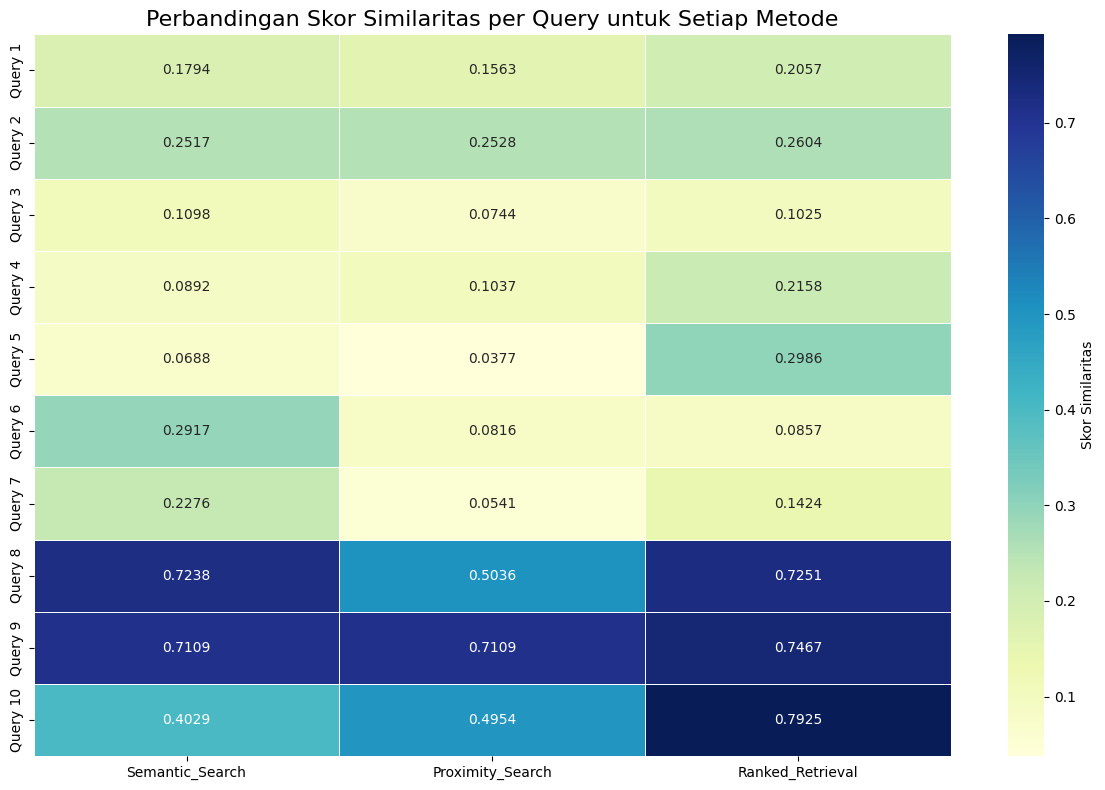

<Figure size 1400x1000 with 0 Axes>

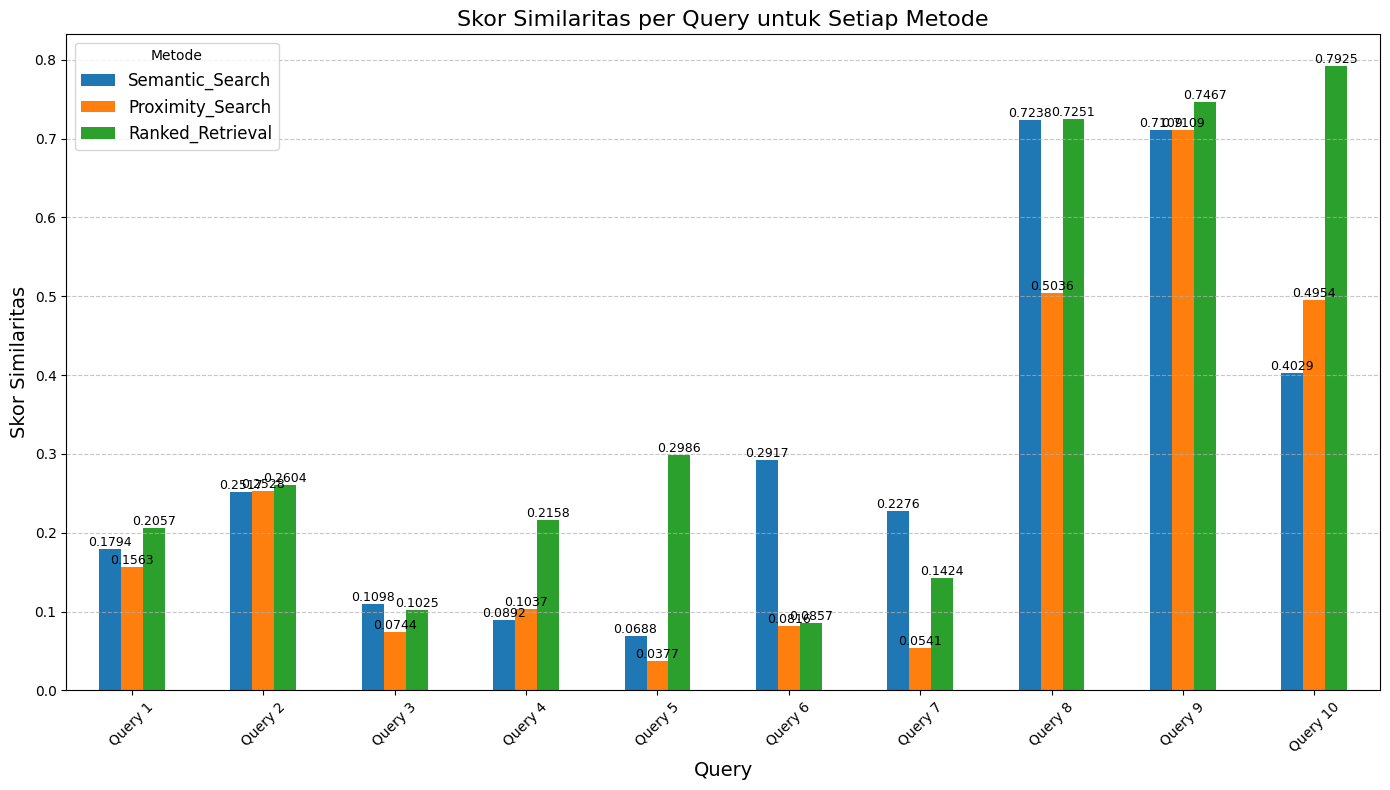

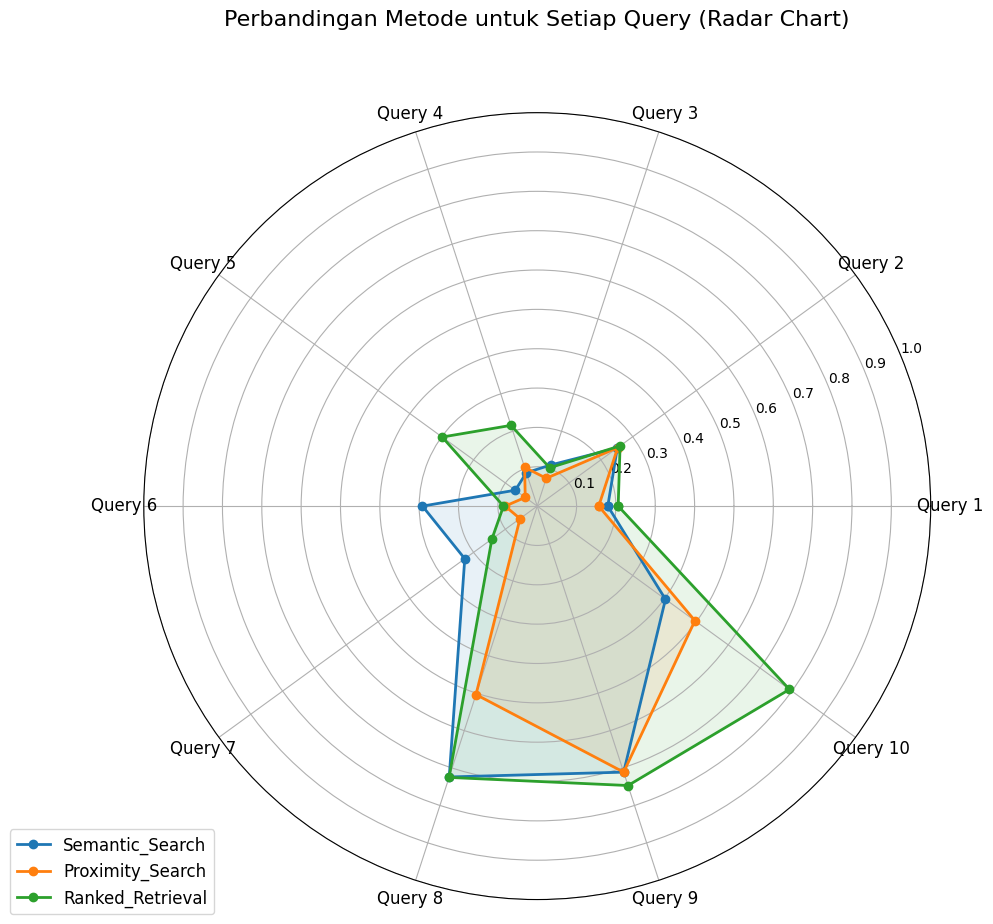

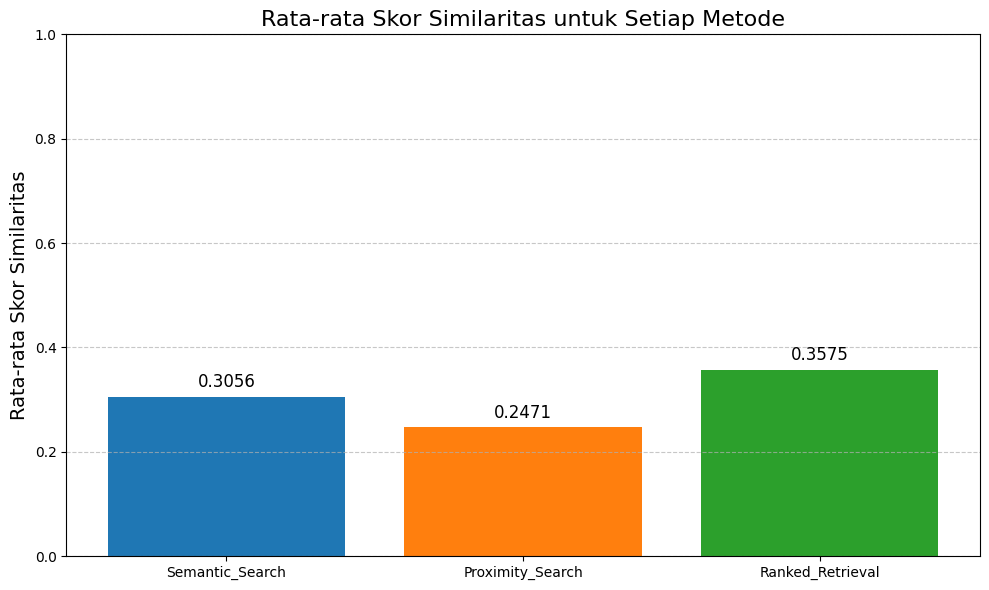

In [98]:
visualize_query_comparison(results, test_queries)

In [102]:
# Statistical analysis
stats = statistical_analysis(results)
stats


Descriptive Statistics:
       Semantic_Search  Proximity_Search  Ranked_Retrieval
count        10.000000         10.000000         10.000000
mean          0.305580          0.247059          0.357534
std           0.239222          0.237990          0.282257
min           0.068785          0.037673          0.085713
25%           0.127175          0.076204          0.158226
50%           0.239662          0.130001          0.238060
75%           0.375109          0.434787          0.618441
max           0.723821          0.710927          0.792503

Paired t-test results:
Semantic_Search vs Proximity_Search: t-stat = 1.7556, p-value = 0.1131
  No significant difference detected.
Semantic_Search vs Ranked_Retrieval: t-stat = -0.9950, p-value = 0.3458
  No significant difference detected.
Proximity_Search vs Ranked_Retrieval: t-stat = -3.1851, p-value = 0.0111
  Significant difference detected! Ranked_Retrieval is better.


,Semantic_Search,Proximity_Search,Ranked_Retrieval
count,10.000000,10.000000,10.000000
mean,0.305580,0.247059,0.357534
std,0.239222,0.237990,0.282257
min,0.068785,0.037673,0.085713
25%,0.127175,0.076204,0.158226
50%,0.239662,0.130001,0.238060
75%,0.375109,0.434787,0.618441
max,0.723821,0.710927,0.792503


from matplotlib import pyplot as plt
stats['Semantic_Search'].plot(kind='hist', bins=20, title='Semantic_Search')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
stats['Proximity_Search'].plot(kind='hist', bins=20, title='Proximity_Search')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
stats['Ranked_Retrieval'].plot(kind='hist', bins=20, title='Ranked_Retrieval')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
stats.plot(kind='scatter', x='Semantic_Search', y='Proximity_Search', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
stats.plot(kind='scatter', x='Proximity_Search', y='Ranked_Retrieval', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
stats['Semantic_Search'].plot(kind='line', figsize=(8, 4), title='Semantic_Search')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
stats['Proximity_Search'].plot(kind='line', figsize=(8, 4), title='Proximity_Search')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
stats['Ranked_Retrieval'].plot(kind='line', figsize=(8, 4), title='Ranked_Retrieval')
plt.gca().spines[['top', 'right']].set_visible(False)

In [100]:
# Determine best method
best_method, best_counts = determine_best_method(results)


Best method based on average similarity: Ranked_Retrieval with score 0.3575

Number of times each method performed best:
Ranked_Retrieval: 7 times (70.0%)
Semantic_Search: 3 times (30.0%)


In [104]:
df_results = pd.DataFrame(results, index=test_queries)
print("\nSimilarity Scores for Each Query:")
df_results


Similarity Scores for Each Query:


,Semantic_Search,Proximity_Search,Ranked_Retrieval
Apa visi Institut Teknologi Del?,0.179374,0.156347,0.205719
Apa saja fakultas dan program studi di Institut Teknologi Del,0.251725,0.252842,0.260358
Apa saja fasilitas akademik yang tersedia di Institut Teknologi Del?,0.109776,0.074419,0.102495
Apa jenis beasiswa yang ditawarkan Institut Teknologi Del untuk mahasiswa,0.089196,0.103655,0.215761
Dimana lokasi kampus Institut Teknologi Del,0.068785,0.037673,0.298613
Apa saja prestasi dan keunggulan yang telah diraih oleh Institut Teknologi Del?,0.291671,0.081561,0.085713
Apa rutinitas sehari-hari yang dijalani oleh mahasiswa Institut Teknologi Del?,0.227599,0.054144,0.142395
Apa peran dan tujuan dari Pusat Pengembangan Karir dan Alumni di Institut Teknologi Del?,0.723821,0.503593,0.725051
Apa layanan dan program yang disediakan oleh UPT Pusat Bahasa di Institut Teknologi Del?,0.710927,0.710927,0.746734
Apa saja organisasi mahasiswa yang ada di Institut Teknologi Del dan bagaimana peran mereka dalam pengembangan mahasiswa?,0.402922,0.495436,0.792503
